In [8]:
%pip install pathlib
%pip install numpy
%pip install pandas
%pip install pillow
%pip install torch
%pip install torchvision
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.0-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (113 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)

In [9]:
import os
from pathlib import Path
import json

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

from sklearn.metrics import roc_curve, auc, r2_score

import matplotlib.pyplot as plt


In [10]:
# === PATHS – ADJUST IF NEEDED ===
# Notebook is in repo root; pictures in picture/<description>/filename.png
BASE_PICTURE_DIR = Path("picture")

# JSON label files (one per description)
LABELS_DIR = Path("labels")

# Where to save trained model
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)
MODEL_PATH = MODEL_DIR / "car_count_resnet18.pth"

# Training hyperparameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 40          # we'll use early stopping, so it's safe to be high
LEARNING_RATE = 1e-4
VAL_SPLIT = 0.2
PATIENCE = 8             # early stopping patience (epochs)
RANDOM_SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [11]:
all_rows = []

if not LABELS_DIR.exists():
    raise FileNotFoundError(f"Labels directory not found: {LABELS_DIR.resolve()}")

for json_path in LABELS_DIR.glob("*_labels.json"):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if not isinstance(data, list):
        continue

    for entry in data:
        # Skip images marked as issue or missing count
        if entry.get("error") == "YES":
            continue
        if entry.get("car_amount") is None:
            continue

        desc = entry.get("description")
        filename = entry.get("filename")

        # Try picture/<description>/filename, then picture/filename
        path1 = BASE_PICTURE_DIR / desc / filename
        path2 = BASE_PICTURE_DIR / filename

        if path1.exists():
            img_path = path1
        elif path2.exists():
            img_path = path2
        else:
            # silently skip missing images
            continue

        all_rows.append({
            "filepath": str(img_path),
            "description": desc,
            "filename": filename,
            "car_amount": int(entry["car_amount"]),
            "date": entry.get("date"),
            "time": entry.get("time"),
            "description_total": entry.get("description_total", None)
        })

df = pd.DataFrame(all_rows)
print("Total labeled images:", len(df))
df.head()


Total labeled images: 314


,filepath,description,filename,car_amount,date,time,description_total
0,picture/2nd_Ave_49_st/2nd_Ave_49_st_1.png,2nd_Ave_49_st,2nd_Ave_49_st_1.png,9,2025-12-08,12-57-30,1
1,picture/2nd_Ave_49_st/2nd_Ave_49_st_2.png,2nd_Ave_49_st,2nd_Ave_49_st_2.png,6,2025-12-08,12-58-30,2
2,picture/2nd_Ave_49_st/2nd_Ave_49_st_3.png,2nd_Ave_49_st,2nd_Ave_49_st_3.png,7,2025-12-08,12-59-30,3
3,picture/2nd_Ave_49_st/2nd_Ave_49_st_4.png,2nd_Ave_49_st,2nd_Ave_49_st_4.png,7,2025-12-08,13-00-30,4
4,picture/2nd_Ave_49_st/2nd_Ave_49_st_5.png,2nd_Ave_49_st,2nd_Ave_49_st_5.png,7,2025-12-08,13-01-30,5


count    314.000000
mean       3.917197
std        2.093537
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: car_amount, dtype: float64


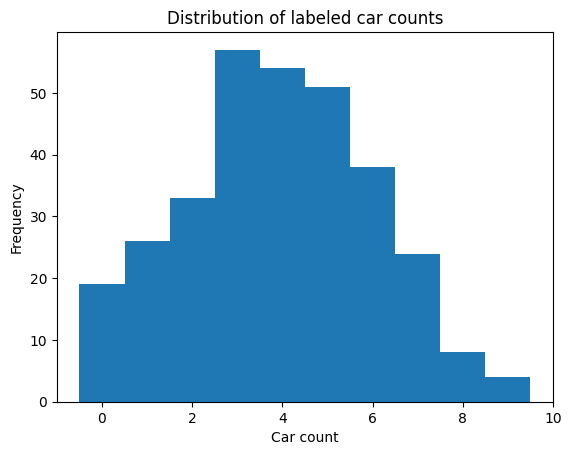

In [12]:
print(df["car_amount"].describe())
plt.figure()
plt.hist(df["car_amount"], bins=range(int(df["car_amount"].max()) + 2), align="left")
plt.xlabel("Car count")
plt.ylabel("Frequency")
plt.title("Distribution of labeled car counts")
plt.show()


In [13]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


class CarCountDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        target = torch.tensor(row["car_amount"], dtype=torch.float32)
        return img, target


In [14]:
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

full_dataset = CarCountDataset(df, transform=train_transform)

val_size = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset_indices = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

# re-wrap validation dataset with val_transform
val_df = df.iloc[val_dataset_indices.indices].reset_index(drop=True)
val_dataset = CarCountDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

len(train_dataset), len(val_dataset)


(252, 62)

In [15]:
def create_resnet18_regressor():
    # Pretrained on ImageNet; first run will download weights
    backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Replace final FC with regression head
    in_features = backbone.fc.in_features
    backbone.fc = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(256, 1)
    )

    return backbone

model = create_resnet18_regressor().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-6
)

model


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 85.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
def evaluate(model, loader, collect_outputs=False):
    model.eval()
    total_mse = 0.0
    total_mae = 0.0
    n = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images).squeeze(1)  # (batch,)

            loss = criterion(outputs, targets)
            total_mse += loss.item() * targets.size(0)
            total_mae += torch.abs(outputs - targets).sum().item()
            n += targets.size(0)

            if collect_outputs:
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

    mse = total_mse / n
    mae = total_mae / n

    if collect_outputs:
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        return mse, mae, all_preds, all_targets

    return mse, mae


In [18]:
history = {
    "train_mse": [],
    "train_mae": [],
    "val_mse": [],
    "val_mae": [],
}

best_val_mae = float("inf")
epochs_no_improve = 0

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_mse = 0.0
    running_mae = 0.0
    n_train = 0

    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze(1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        batch_size = targets.size(0)
        running_mse += loss.item() * batch_size
        running_mae += torch.abs(outputs - targets).sum().item()
        n_train += batch_size

    train_mse = running_mse / n_train
    train_mae = running_mae / n_train

    val_mse, val_mae = evaluate(model, val_loader)

    history["train_mse"].append(train_mse)
    history["train_mae"].append(train_mae)
    history["val_mse"].append(val_mse)
    history["val_mae"].append(val_mae)

    scheduler.step(val_mae)

    print(
        f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
        f"Train MSE: {train_mse:.3f} | Train MAE: {train_mae:.3f} | "
        f"Val MSE: {val_mse:.3f} | Val MAE: {val_mae:.3f}"
    )

    # Early stopping based on val MAE
    if val_mae < best_val_mae - 1e-3:  # small tolerance
        best_val_mae = val_mae
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  🔥 New best model saved to {MODEL_PATH}, val MAE = {val_mae:.3f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping after {epoch} epochs (no val MAE improvement for {PATIENCE} epochs).")
            break


Epoch 01/40 | Train MSE: 11.660 | Train MAE: 2.904 | Val MSE: 6.799 | Val MAE: 2.195
  🔥 New best model saved to models/car_count_resnet18.pth, val MAE = 2.195
Epoch 02/40 | Train MSE: 3.629 | Train MAE: 1.546 | Val MSE: 2.323 | Val MAE: 1.255
  🔥 New best model saved to models/car_count_resnet18.pth, val MAE = 1.255
Epoch 03/40 | Train MSE: 1.225 | Train MAE: 0.848 | Val MSE: 2.040 | Val MAE: 1.202
  🔥 New best model saved to models/car_count_resnet18.pth, val MAE = 1.202
Epoch 04/40 | Train MSE: 0.909 | Train MAE: 0.760 | Val MSE: 1.797 | Val MAE: 1.145
  🔥 New best model saved to models/car_count_resnet18.pth, val MAE = 1.145
Epoch 05/40 | Train MSE: 1.028 | Train MAE: 0.776 | Val MSE: 1.686 | Val MAE: 1.074
  🔥 New best model saved to models/car_count_resnet18.pth, val MAE = 1.074
Epoch 06/40 | Train MSE: 0.644 | Train MAE: 0.618 | Val MSE: 1.726 | Val MAE: 1.040
  🔥 New best model saved to models/car_count_resnet18.pth, val MAE = 1.040
Epoch 07/40 | Train MSE: 0.700 | Train MAE: 0

In [19]:
best_model = create_resnet18_regressor().to(device)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
best_model.eval()

val_mse, val_mae, val_preds, val_targets = evaluate(
    best_model, val_loader, collect_outputs=True
)

print(f"Best model on validation set -> MSE: {val_mse:.3f}, MAE: {val_mae:.3f}")
print(f"R^2 score (val): {r2_score(val_targets, val_preds):.3f}")


Best model on validation set -> MSE: 1.417, MAE: 0.941
R^2 score (val): 0.723


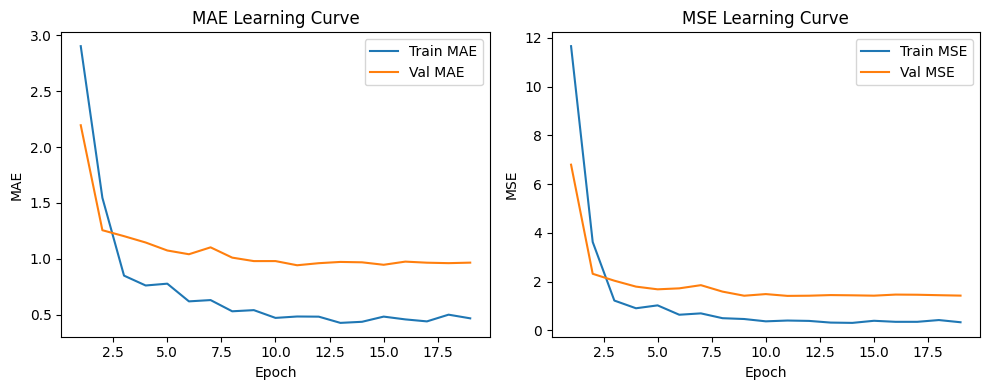

In [20]:
epochs_range = range(1, len(history["train_mse"]) + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, history["train_mae"], label="Train MAE")
plt.plot(epochs_range, history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE Learning Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history["train_mse"], label="Train MSE")
plt.plot(epochs_range, history["val_mse"], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Learning Curve")
plt.legend()

plt.tight_layout()
plt.show()


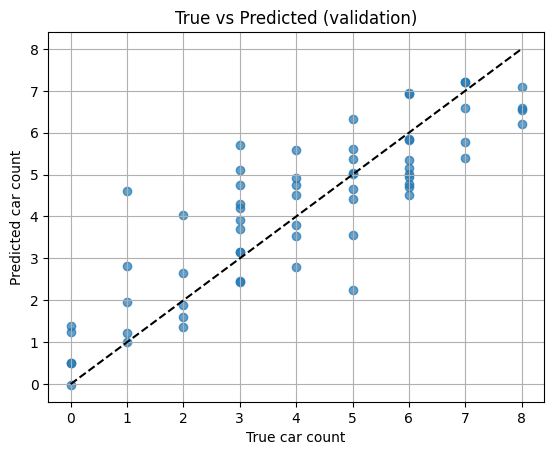

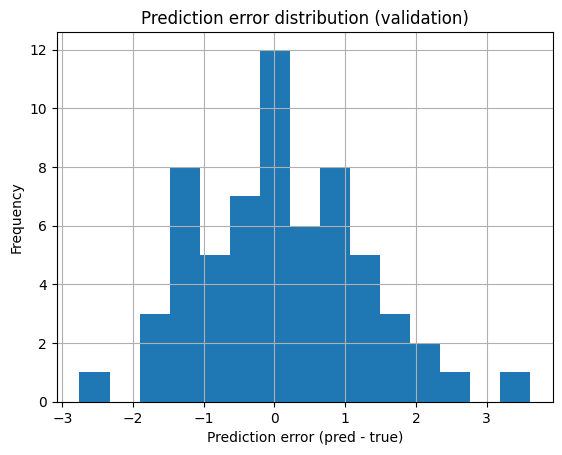

In [21]:
# Scatter: true vs predicted
plt.figure()
plt.scatter(val_targets, val_preds, alpha=0.7)
max_count = max(val_targets.max(), val_preds.max())
plt.plot([0, max_count], [0, max_count], "k--")
plt.xlabel("True car count")
plt.ylabel("Predicted car count")
plt.title("True vs Predicted (validation)")
plt.grid(True)
plt.show()

# Error histogram
errors = val_preds - val_targets
plt.figure()
plt.hist(errors, bins=15)
plt.xlabel("Prediction error (pred - true)")
plt.ylabel("Frequency")
plt.title("Prediction error distribution (validation)")
plt.grid(True)
plt.show()


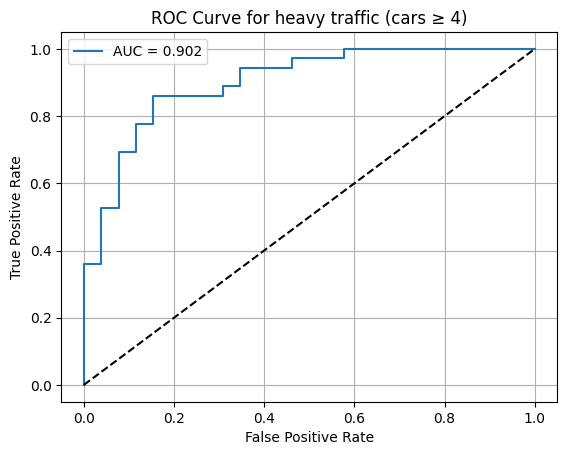

In [22]:
THRESHOLD = 4  # you can experiment with 3, 4, 5, etc.

y_true_bin = (val_targets >= THRESHOLD).astype(int)
y_scores = val_preds  # higher prediction ⇒ more cars ⇒ more likely heavy

fpr, tpr, thr = roc_curve(y_true_bin, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for heavy traffic (cars ≥ {THRESHOLD})")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
single_image_transform = val_transform  # same as validation


def predict_cars(image_path: str, model=best_model):
    img = Image.open(image_path).convert("RGB")
    x = single_image_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(x).squeeze(1).item()
    return max(0, int(round(pred)))


# Example:
example_path = df.iloc[0]["filepath"]
print("Example path:", example_path)
print("True count:   ", df.iloc[0]["car_amount"])
print("Predicted:    ", predict_cars(example_path))


Example path: picture/2nd_Ave_49_st/2nd_Ave_49_st_1.png
True count:    9
Predicted:     8
